# Importing packages

In [283]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [284]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [285]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [286]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "DescFits_red025_rand4200_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250513_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_descFits_red025_rand4200_", 
                                     folderName_common= "250513_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [287]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [288]:
#parameters of SVM 
red_factor = 0.25

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

# rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.75, 0.9, 1]
rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]


#random seed 
randomSeed = 4200

In [289]:
# import random

# importing our data

In [290]:
dataFileName = "DF_SVM_noNotes_t-60_DescFits_sk__20250506_v1.xlsx"

In [291]:
# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_noNotes_t-60__20250506_v1\DF_SVM_noNotes_t-60_DescFits_sk__20250506_v1.xlsx"

This data set contains descriptive statistics, linear and exponential fits, and demographic information for patients with known cardiac amyloidosis status.  The fits were performed using sklearn linear regression.  No physician note data was included in the dataset. Time was restricted to 60 days prior to oncologic diagnosis through all positive time points.

In [292]:
# Import dataset
dataTable = pd.read_excel(dataFileName, sheet_name = "knownPts", header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

,sex_female,dx_mgus,dx_mm,HematologicTx,RadiationTx,OtherTx,ChemoTx_True,HematologicTx_True,RadiationTx_True,ImmunoTx_True,OtherTx_True,Nucleated RBC_min
0,0,1,0,0,0,0,0,0,0,0,0,0.00
1,1,0,1,0,0,0,1,0,0,0,0,0.00
2,0,1,0,0,0,0,0,0,0,0,0,0.00
3,0,1,0,0,0,0,0,0,0,0,0,0.02
4,0,0,1,1,0,0,1,1,0,0,0,0.00
5,1,0,1,0,0,0,0,0,0,0,0,0.00
6,1,0,1,0,0,0,1,0,0,1,0,0.00
7,0,1,0,0,0,0,0,0,0,0,0,0.00
8,1,0,1,0,0,0,1,0,0,1,0,0.00
9,1,0,1,0,0,0,1,0,0,0,0,0.00


# Setting up classifier

## Scaling data and defining test set

In [293]:
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= randomSeed, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

1.260252075625209

In [294]:
# dataTable.loc[list(y_train.index)]

In [295]:
whatTrainPatients = [dataTable.loc[index, 'DeID'] for index in list(y_train.index)]
print(randomSeed)
if 'T-01' in whatTrainPatients:
    print ("T-01 in training set")

4200


In [296]:
whatTrainPatients

['M-02',
 'Z-01',
 'H-02',
 'B-03',
 'I-01',
 'R-03',
 'C-03',
 'C-01',
 'N-01',
 'F-03',
 'X-02',
 'E-03',
 'T-02',
 'I-03',
 'P-02',
 'N-02',
 'X-01',
 'M-01',
 'W-01',
 'K-02',
 'R-01',
 'F-01',
 'P-01',
 'G-03',
 'E-02',
 'H-01',
 'V-02',
 'N-03',
 'Q-02',
 'A-02',
 'S-02',
 'E-01',
 'G-02',
 'Y-02',
 'O-03']

## define cross validation

In [297]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [298]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.7714285714285715,
 'auc': 0.9111111111111111,
 'score': 0.8412698412698413,
 'C': 0.00390625}

In [299]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.888888888888889,
 'auc': 0.8500000000000001,
 'true neg': 4,
 'false pos': 1,
 'false neg': 0,
 'true pos': 4,
 'precision or PPV': 0.8,
 'recall or TPR': 1.0,
 'specificity or TNR': 0.8}

# alternative models

In [300]:
# alternative models

In [301]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [302]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

ROC:  0.675
F1:  0.6666666666666666


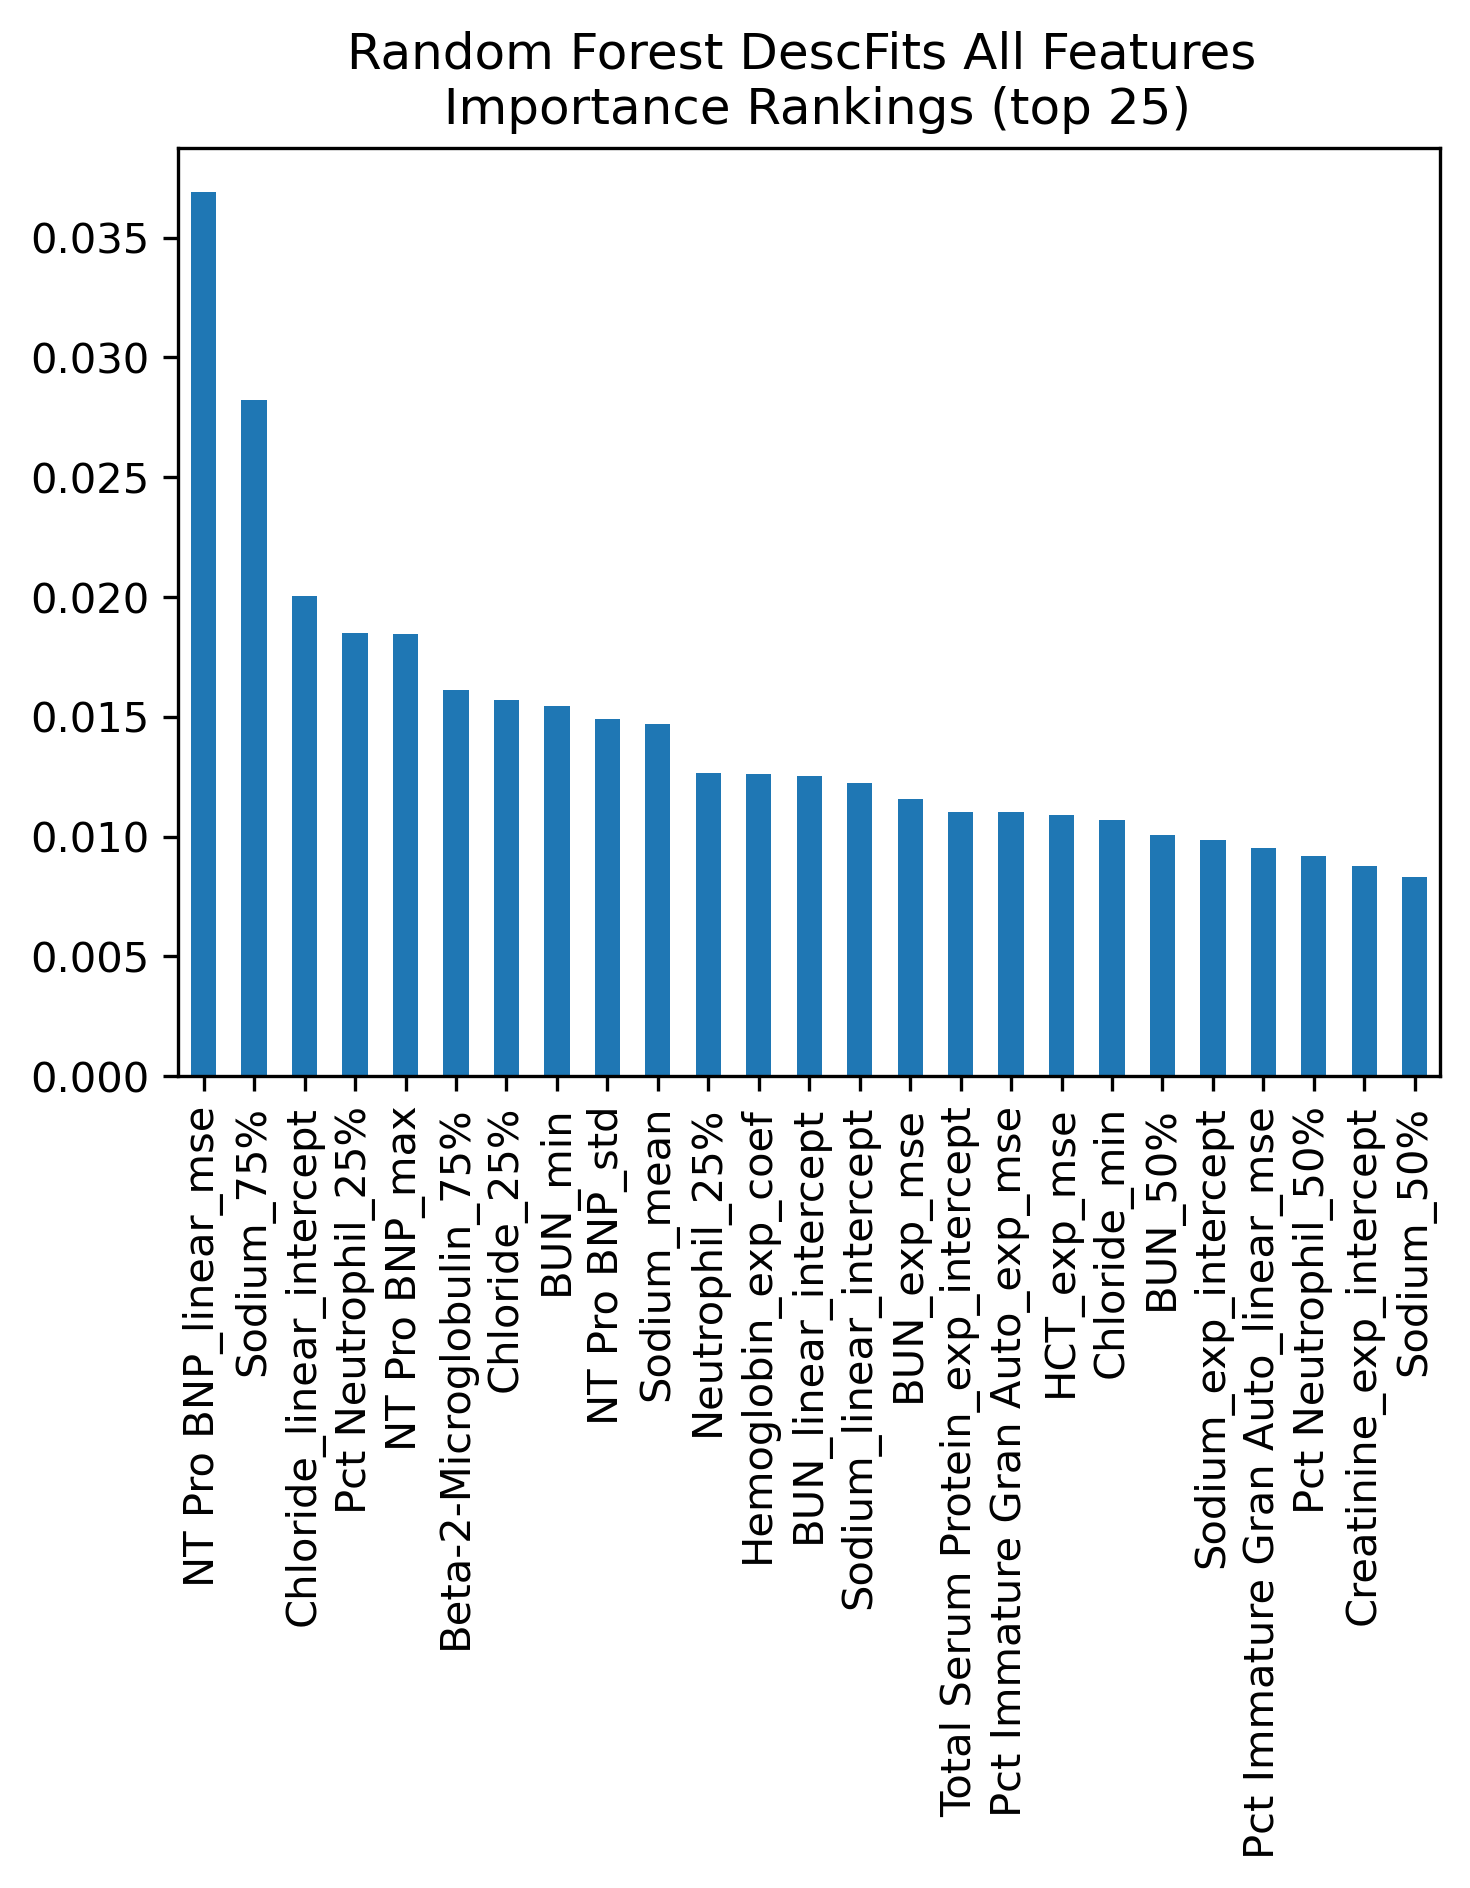

In [303]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(25)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest DescFits All Features \n Importance Rankings (top 25)")

# Show the plot
plt.show()

In [304]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [305]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(what_train[list(top_20_importances.index[:23])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:23])])
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:23])].columns)

ROC:  0.5499999999999999
F1:  0.5


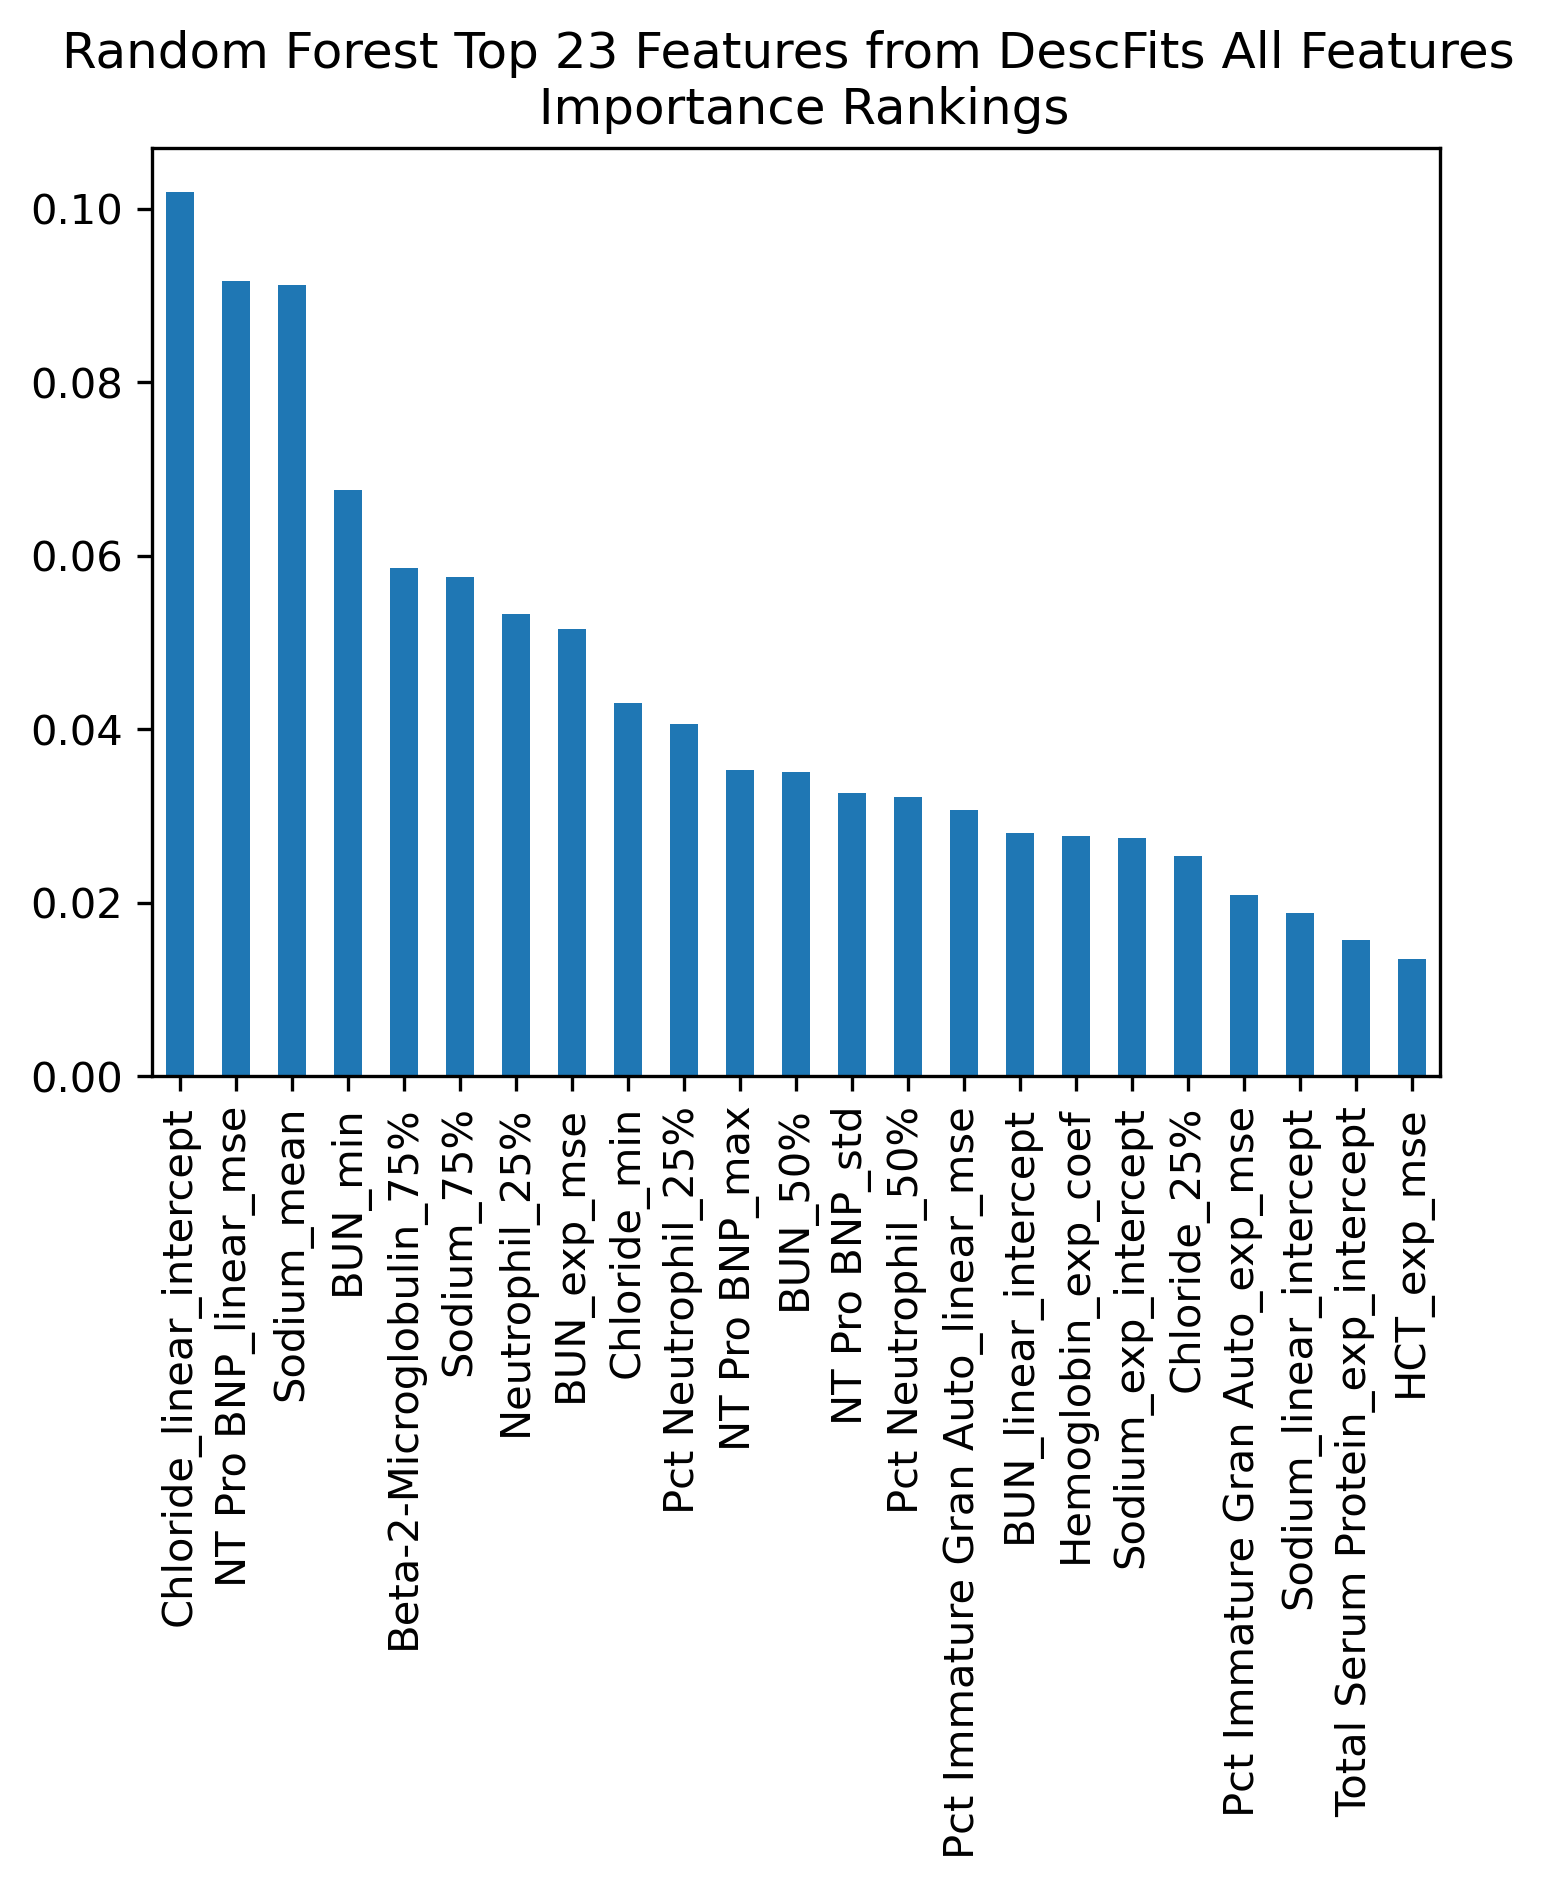

In [306]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 23 Features from DescFits All Features \n Importance Rankings")

# Show the plot
plt.show()

In [307]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

ROC:  0.5499999999999999
F1:  0.5


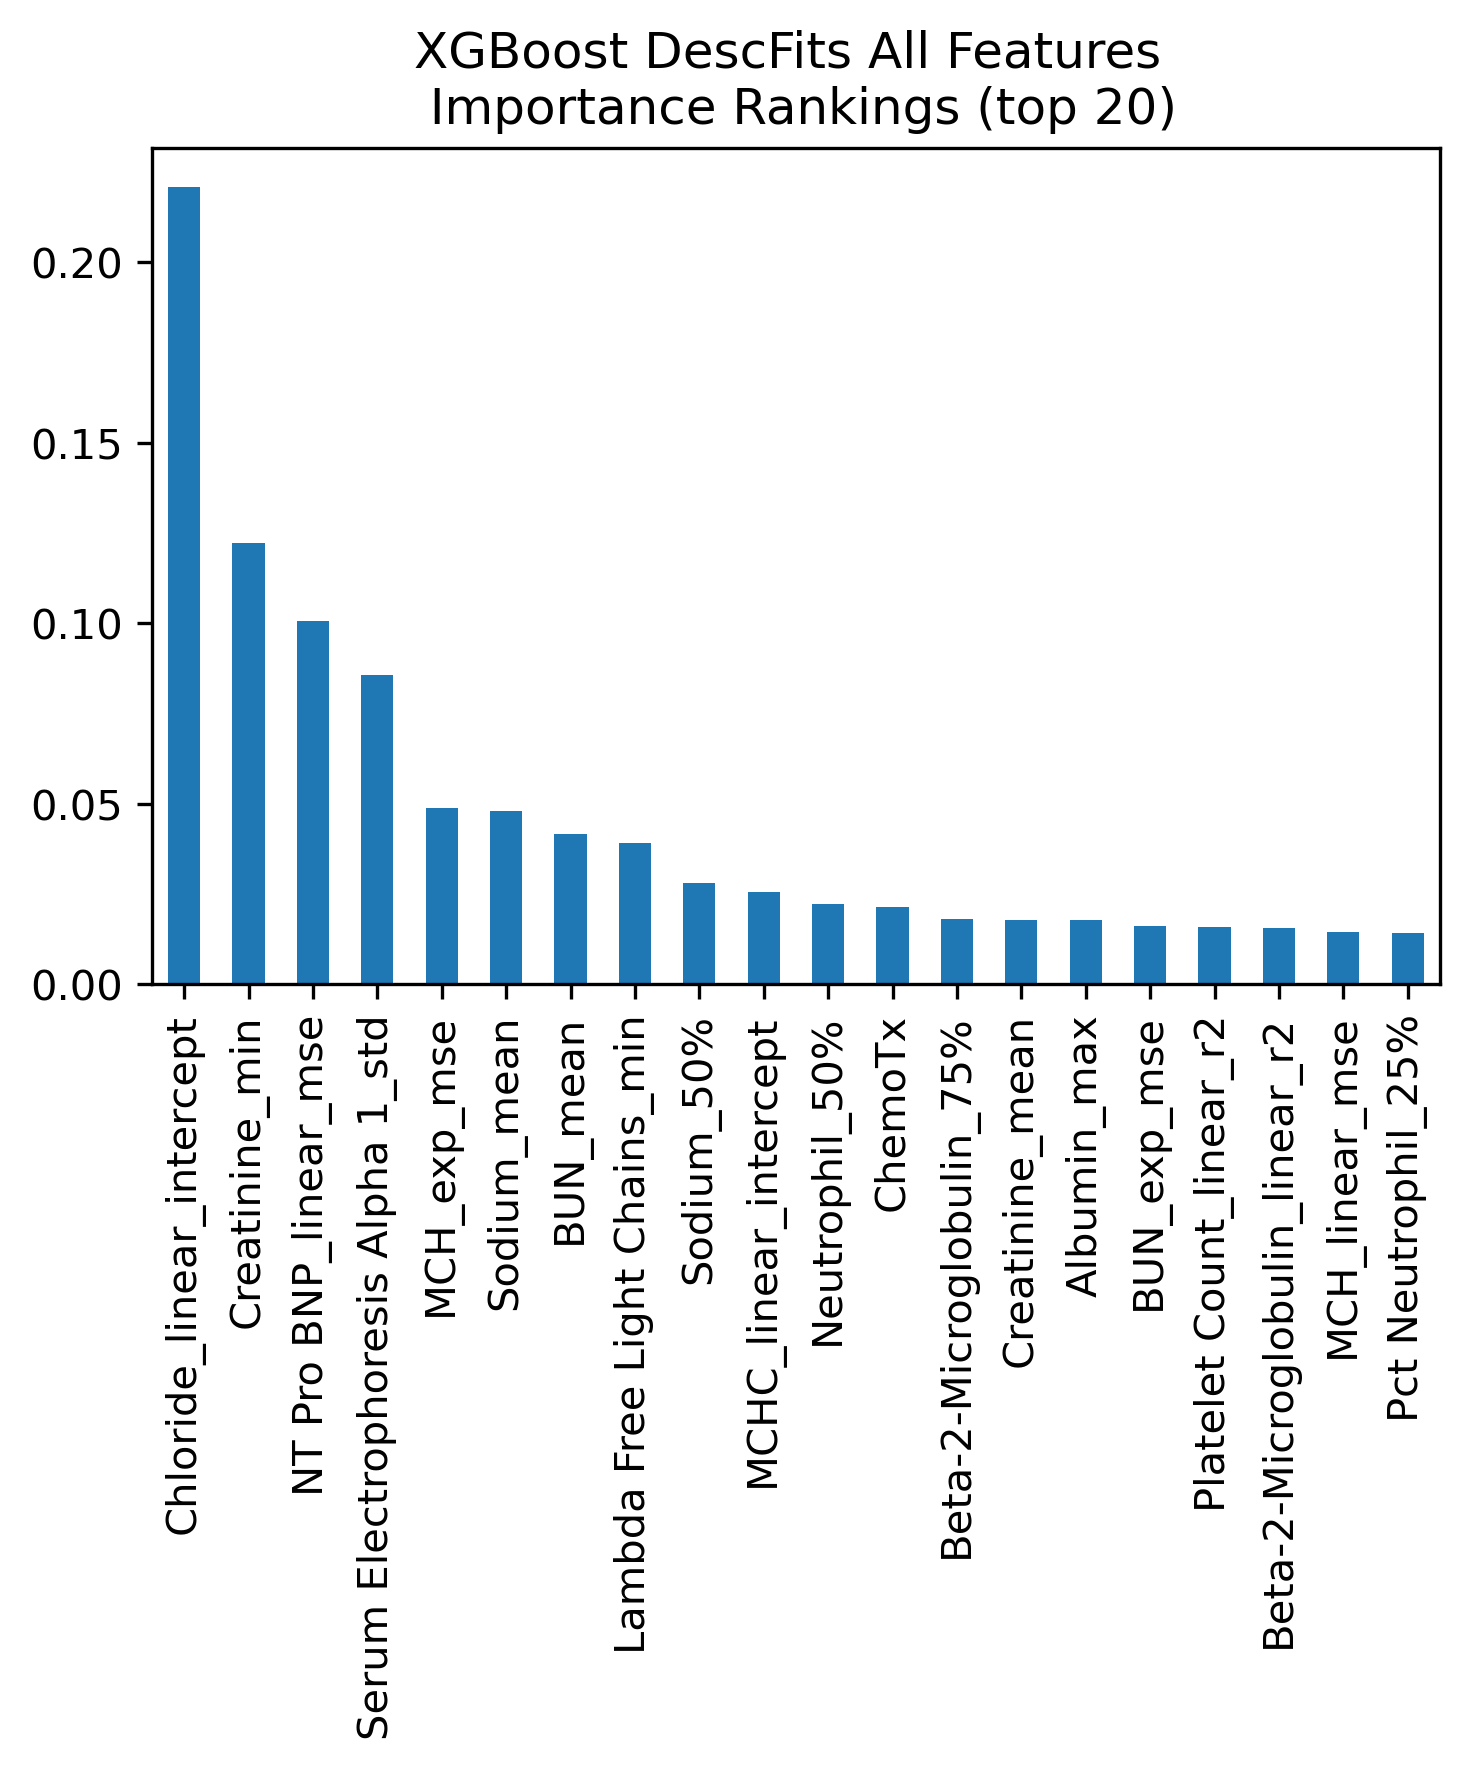

In [308]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost DescFits All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [309]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7396
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No fu

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


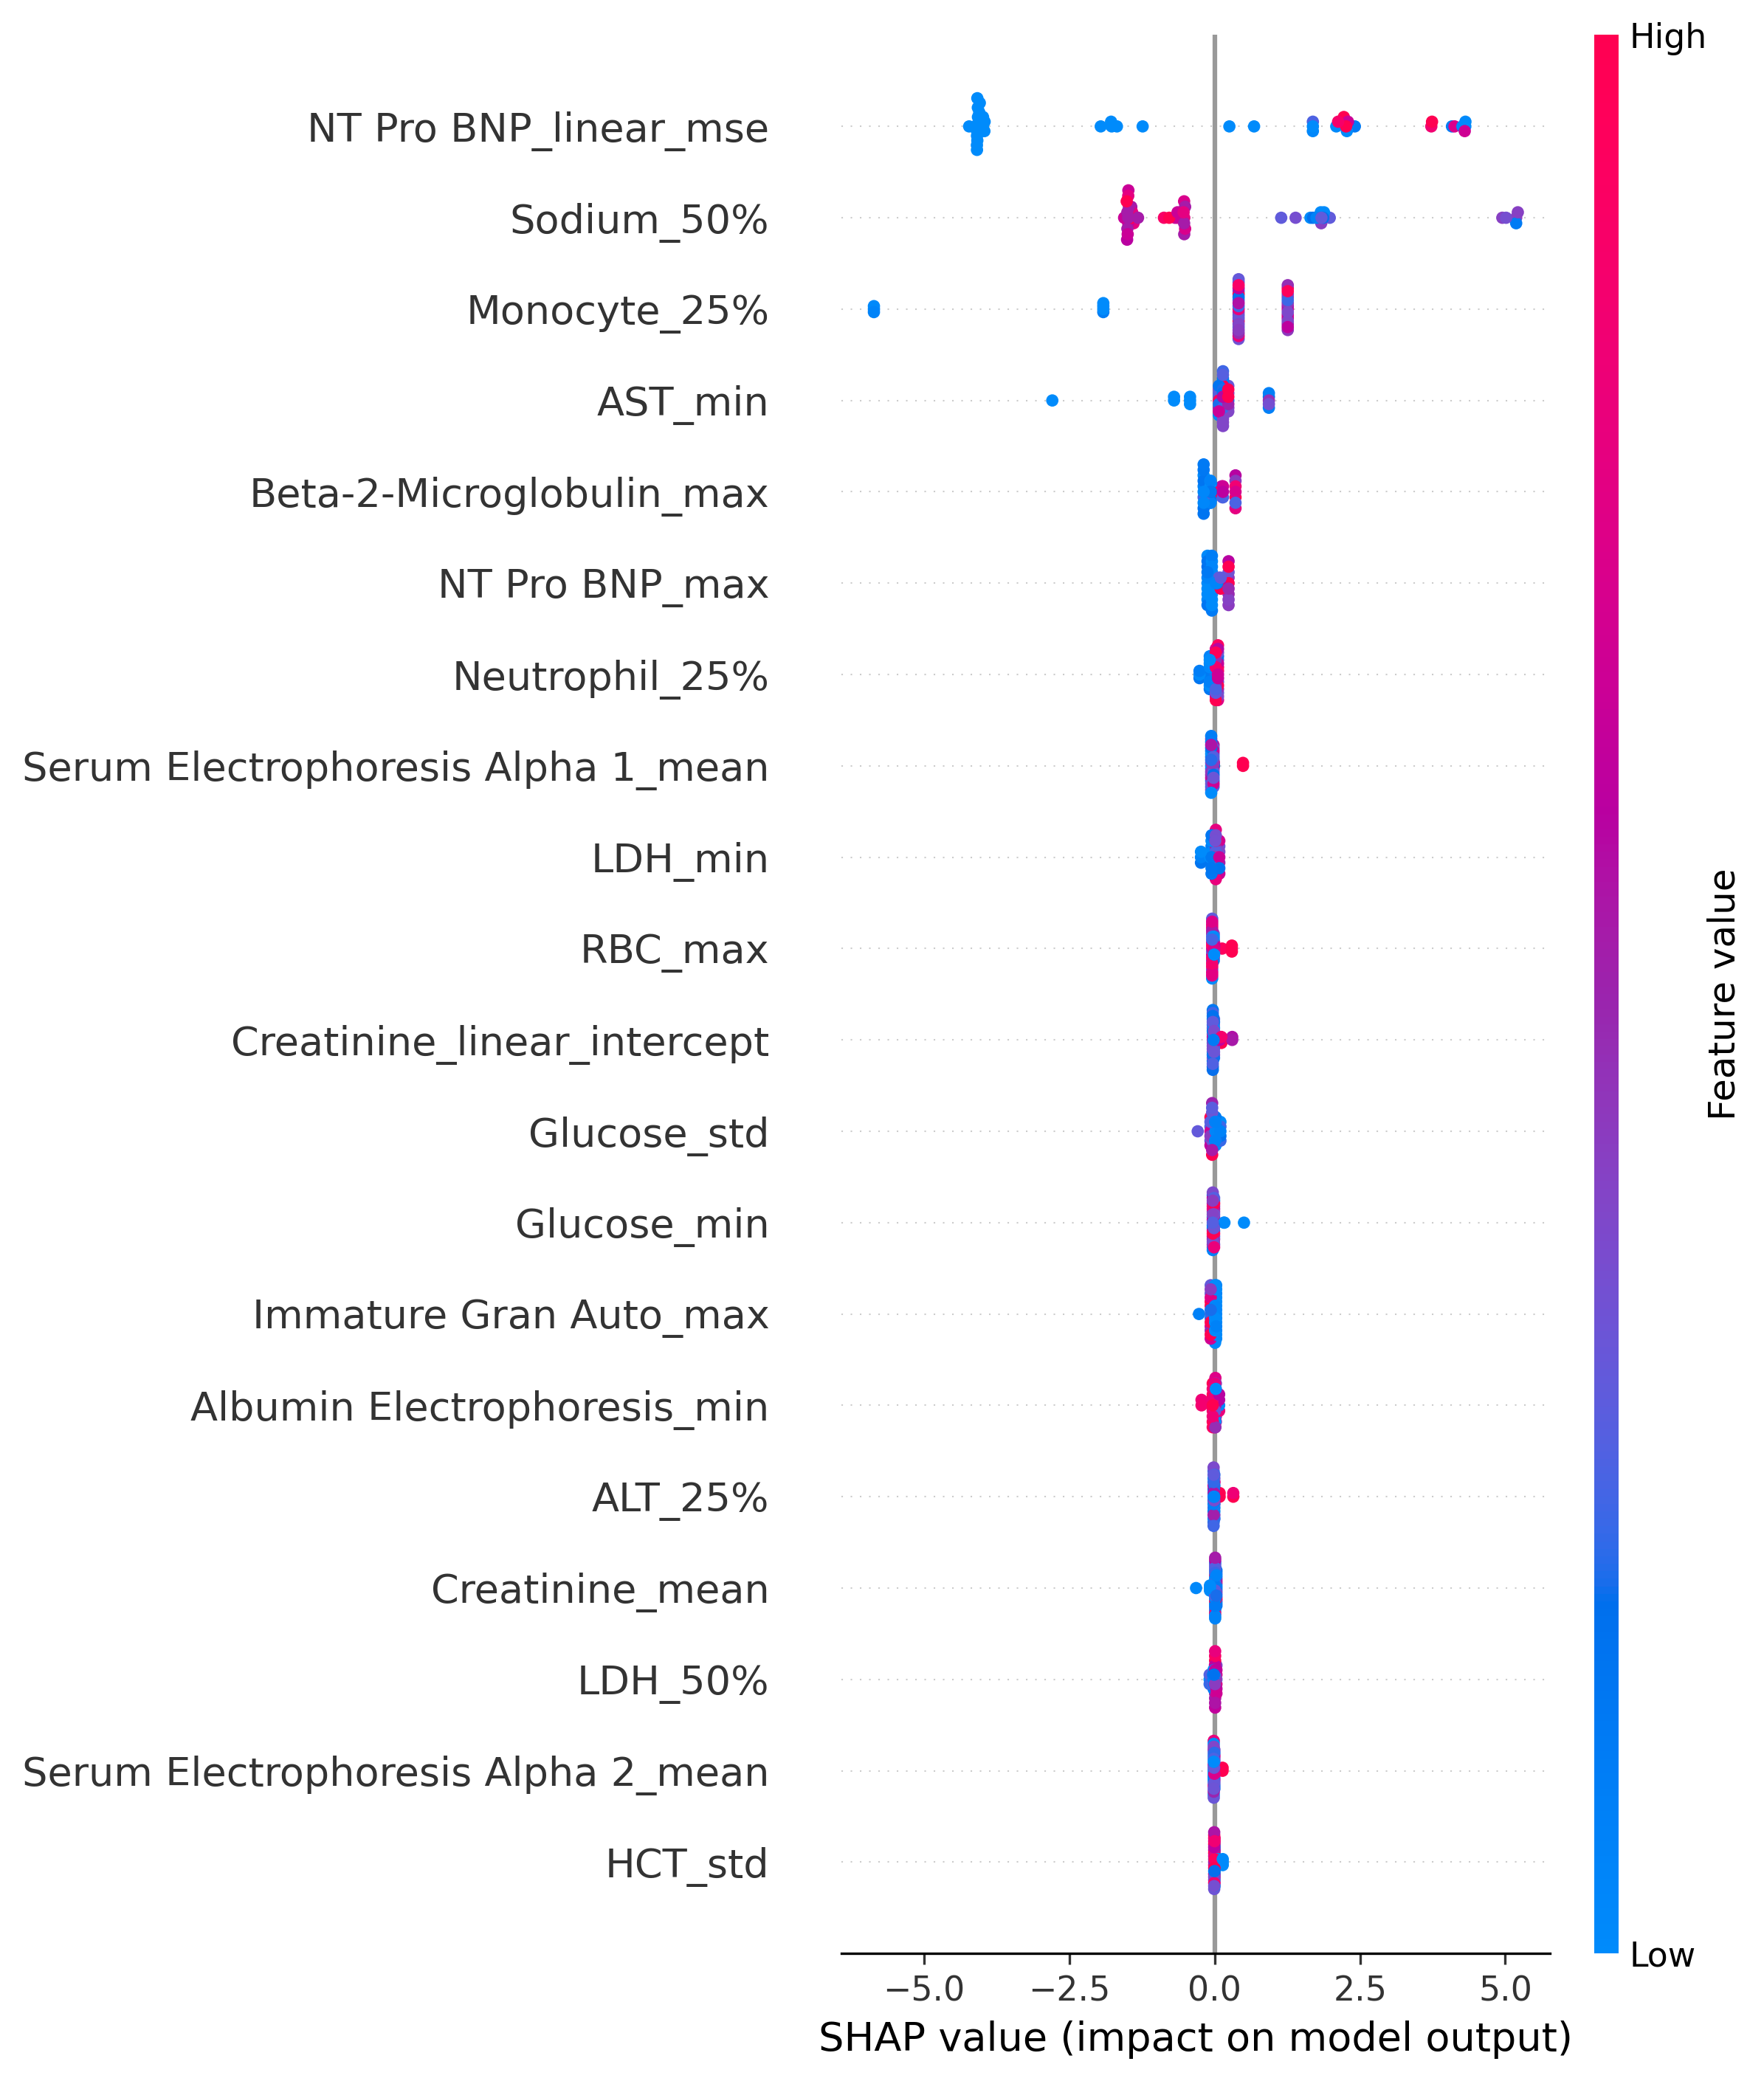

In [310]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [311]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 600, Score: 0.841
Number of Features: 449, Score: 0.841
Number of Features: 336, Score: 0.874
Number of Features: 251, Score: 0.865
Number of Features: 188, Score: 0.857
Number of Features: 140, Score: 0.780
Number of Features: 104, Score: 0.804
Number of Features: 77, Score: 0.807
Number of Features: 57, Score: 0.868
Number of Features: 42, Score: 0.858
Number of Features: 31, Score: 0.838
Number of Features: 23, Score: 0.807
Number of Features: 17, Score: 0.824
Number of Features: 12, Score: 0.787
Number of Features: 8, Score: 0.824
Number of Features: 5, Score: 0.744
Number of Features: 3, Score: 0.813
Number of Features: 2, Score: 0.813
Number of Features: 1, Score: 0.769
Rank weight: 0.15
Number of Features: 600, Score: 0.841
Number of Features: 449, Score: 0.866
Number of Features: 336, Score: 0.904
Number of Features: 251, Score: 0.904
Number of Features: 188, Score: 0.915
Number of Features: 140, Score: 0.866
Number of Features: 104, Score:

# Performance plots

## F1 and AUC plots

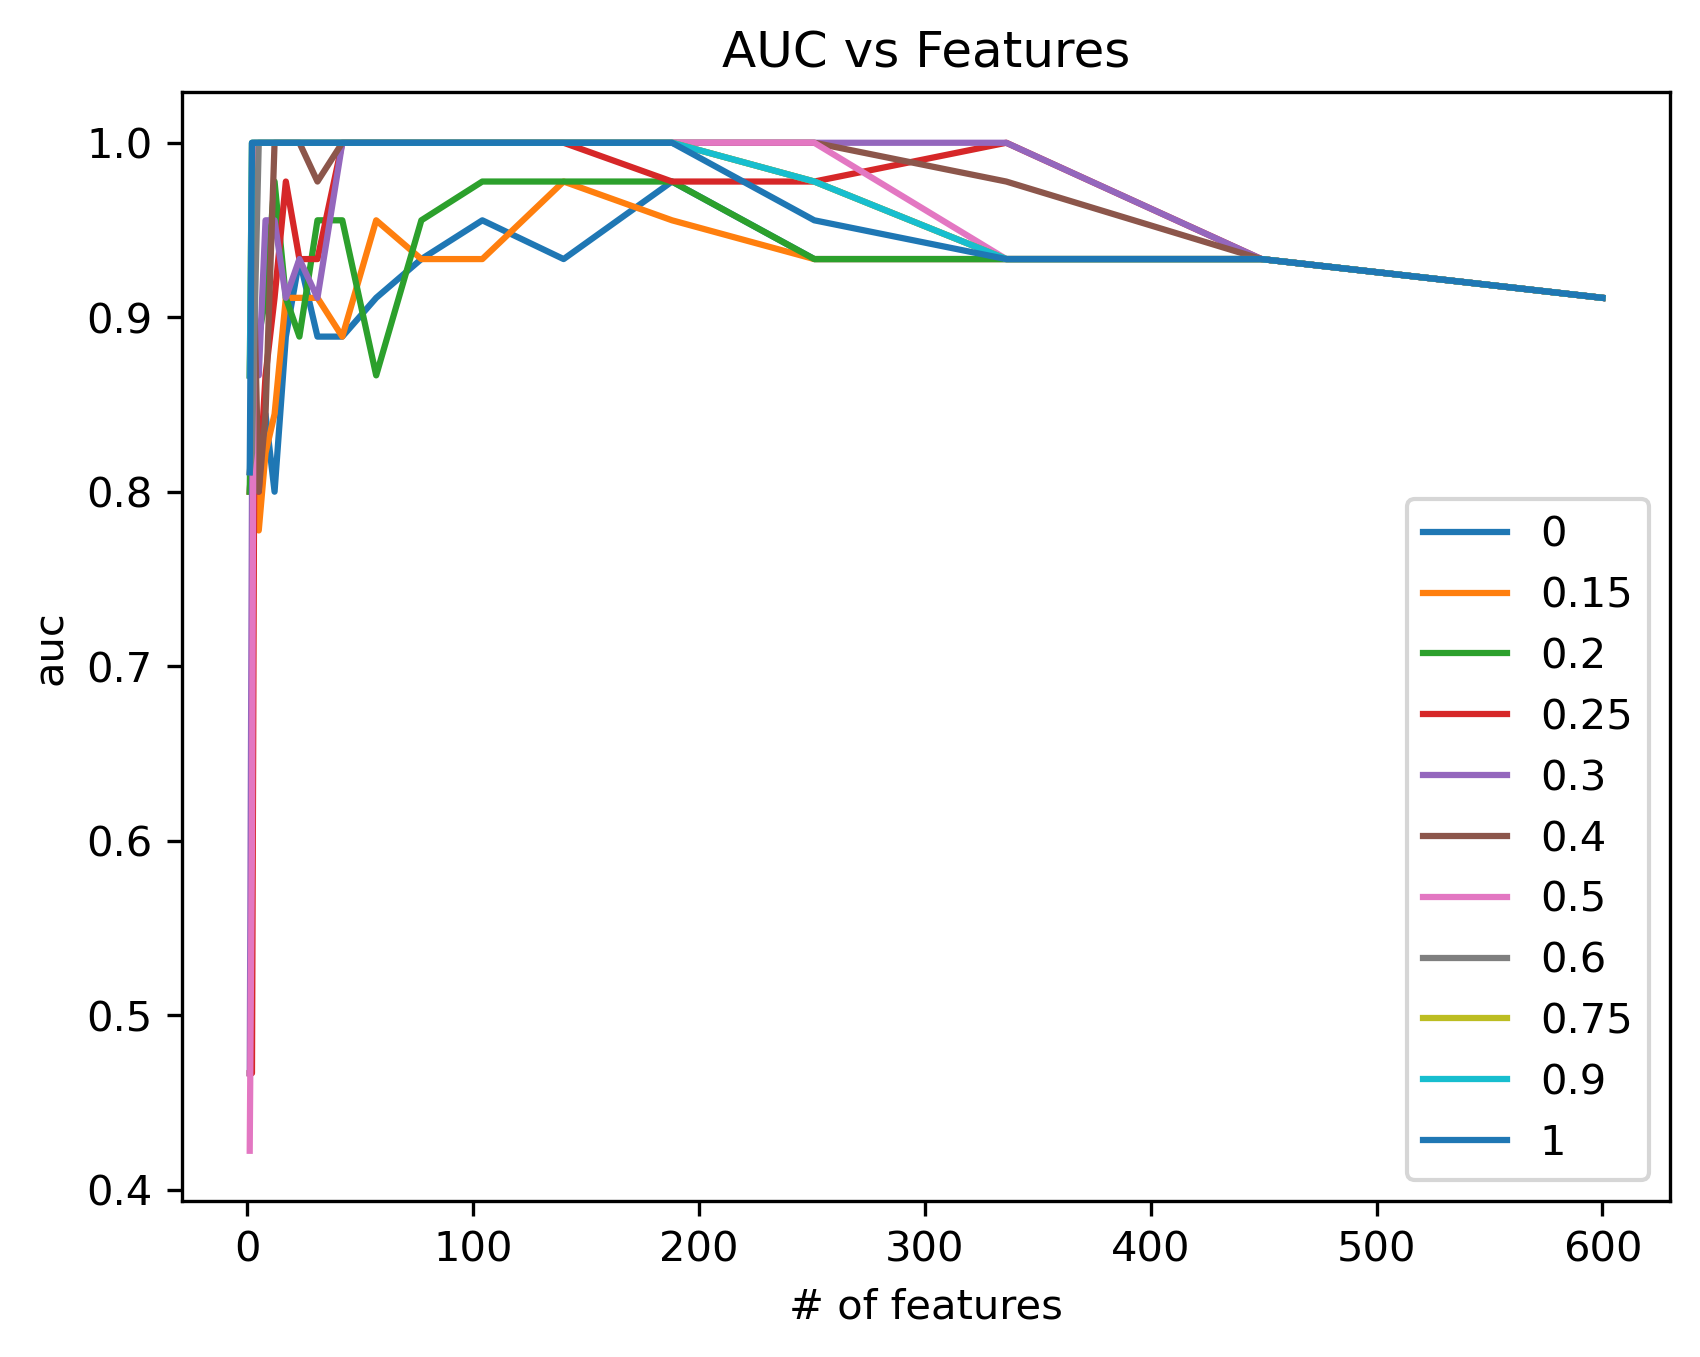

In [312]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

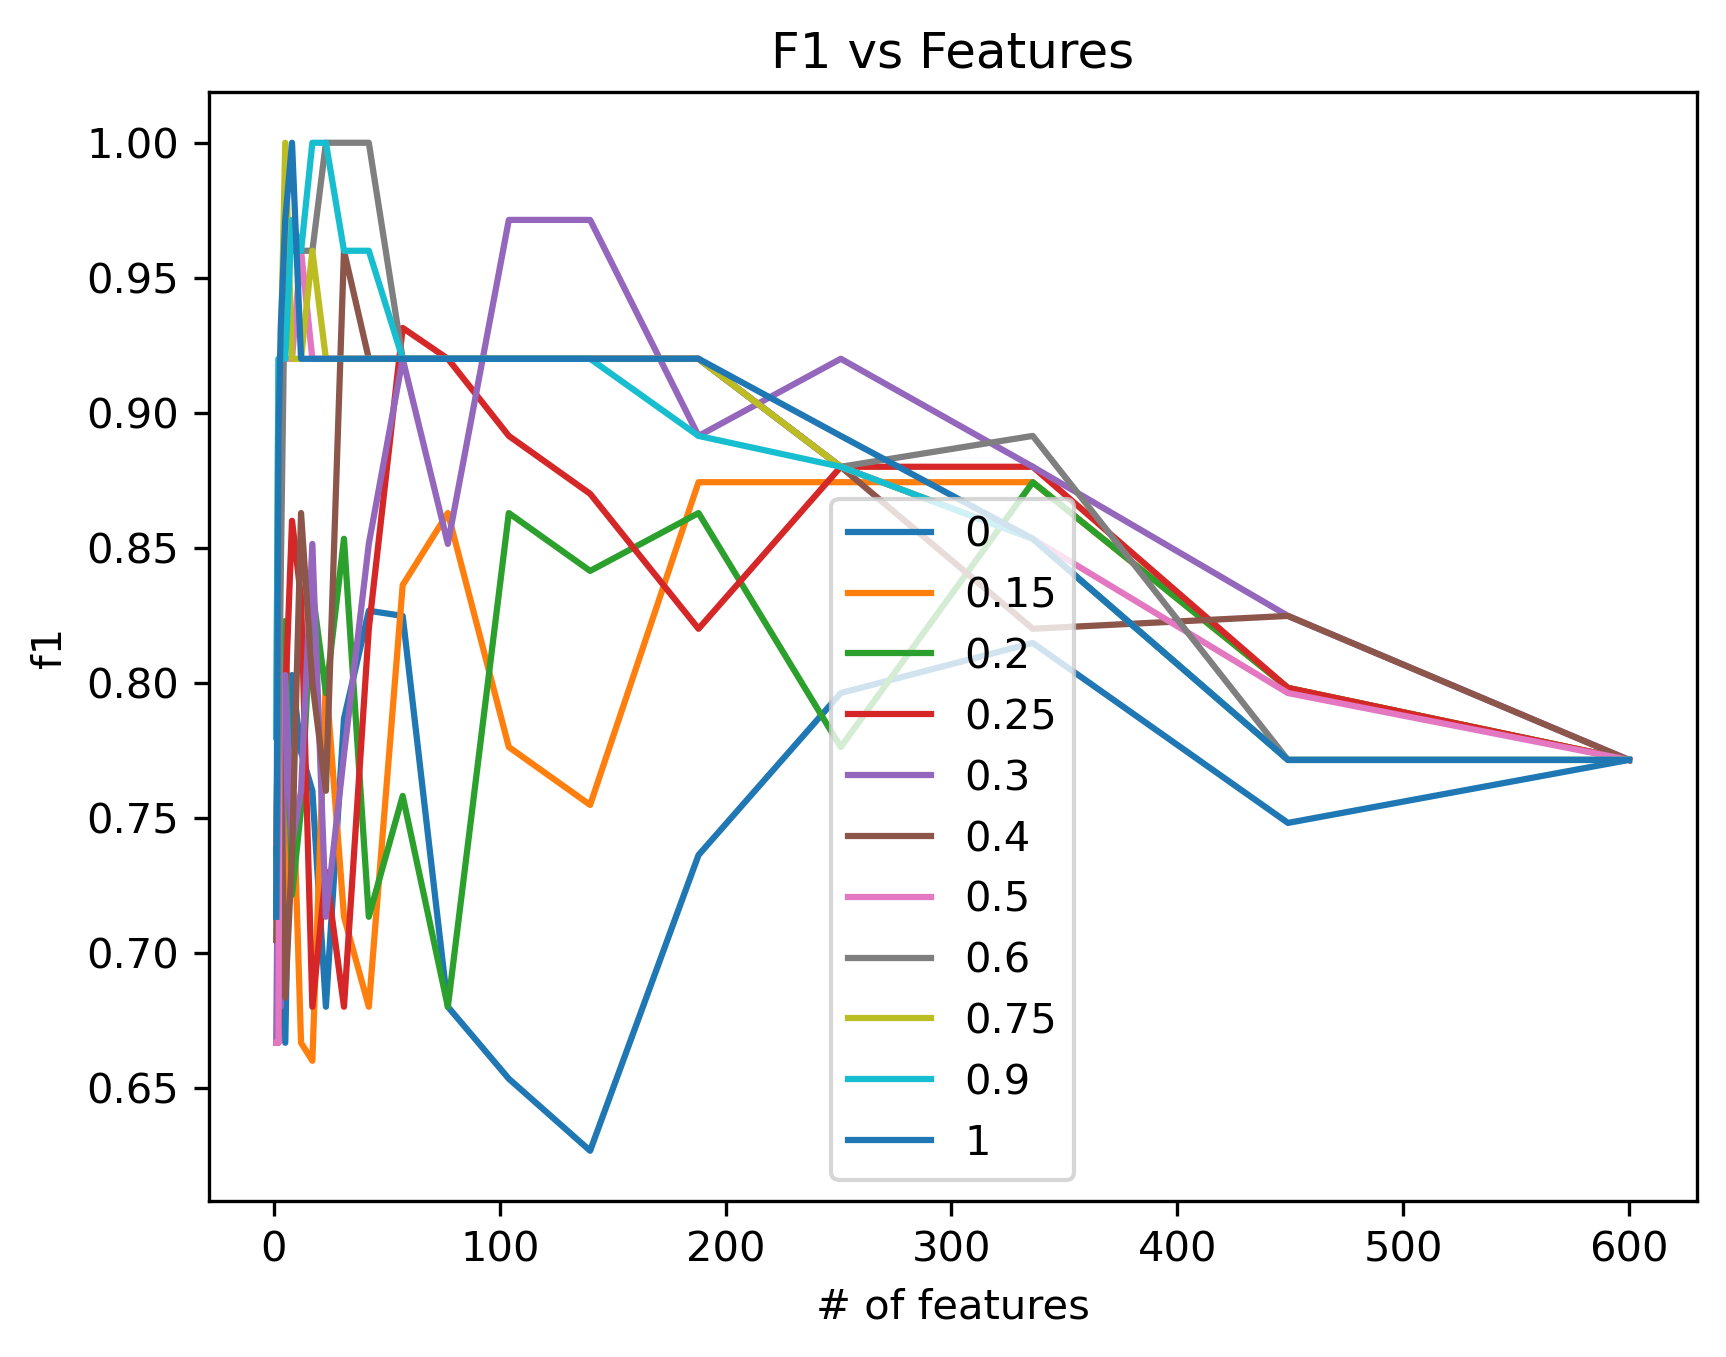

In [313]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

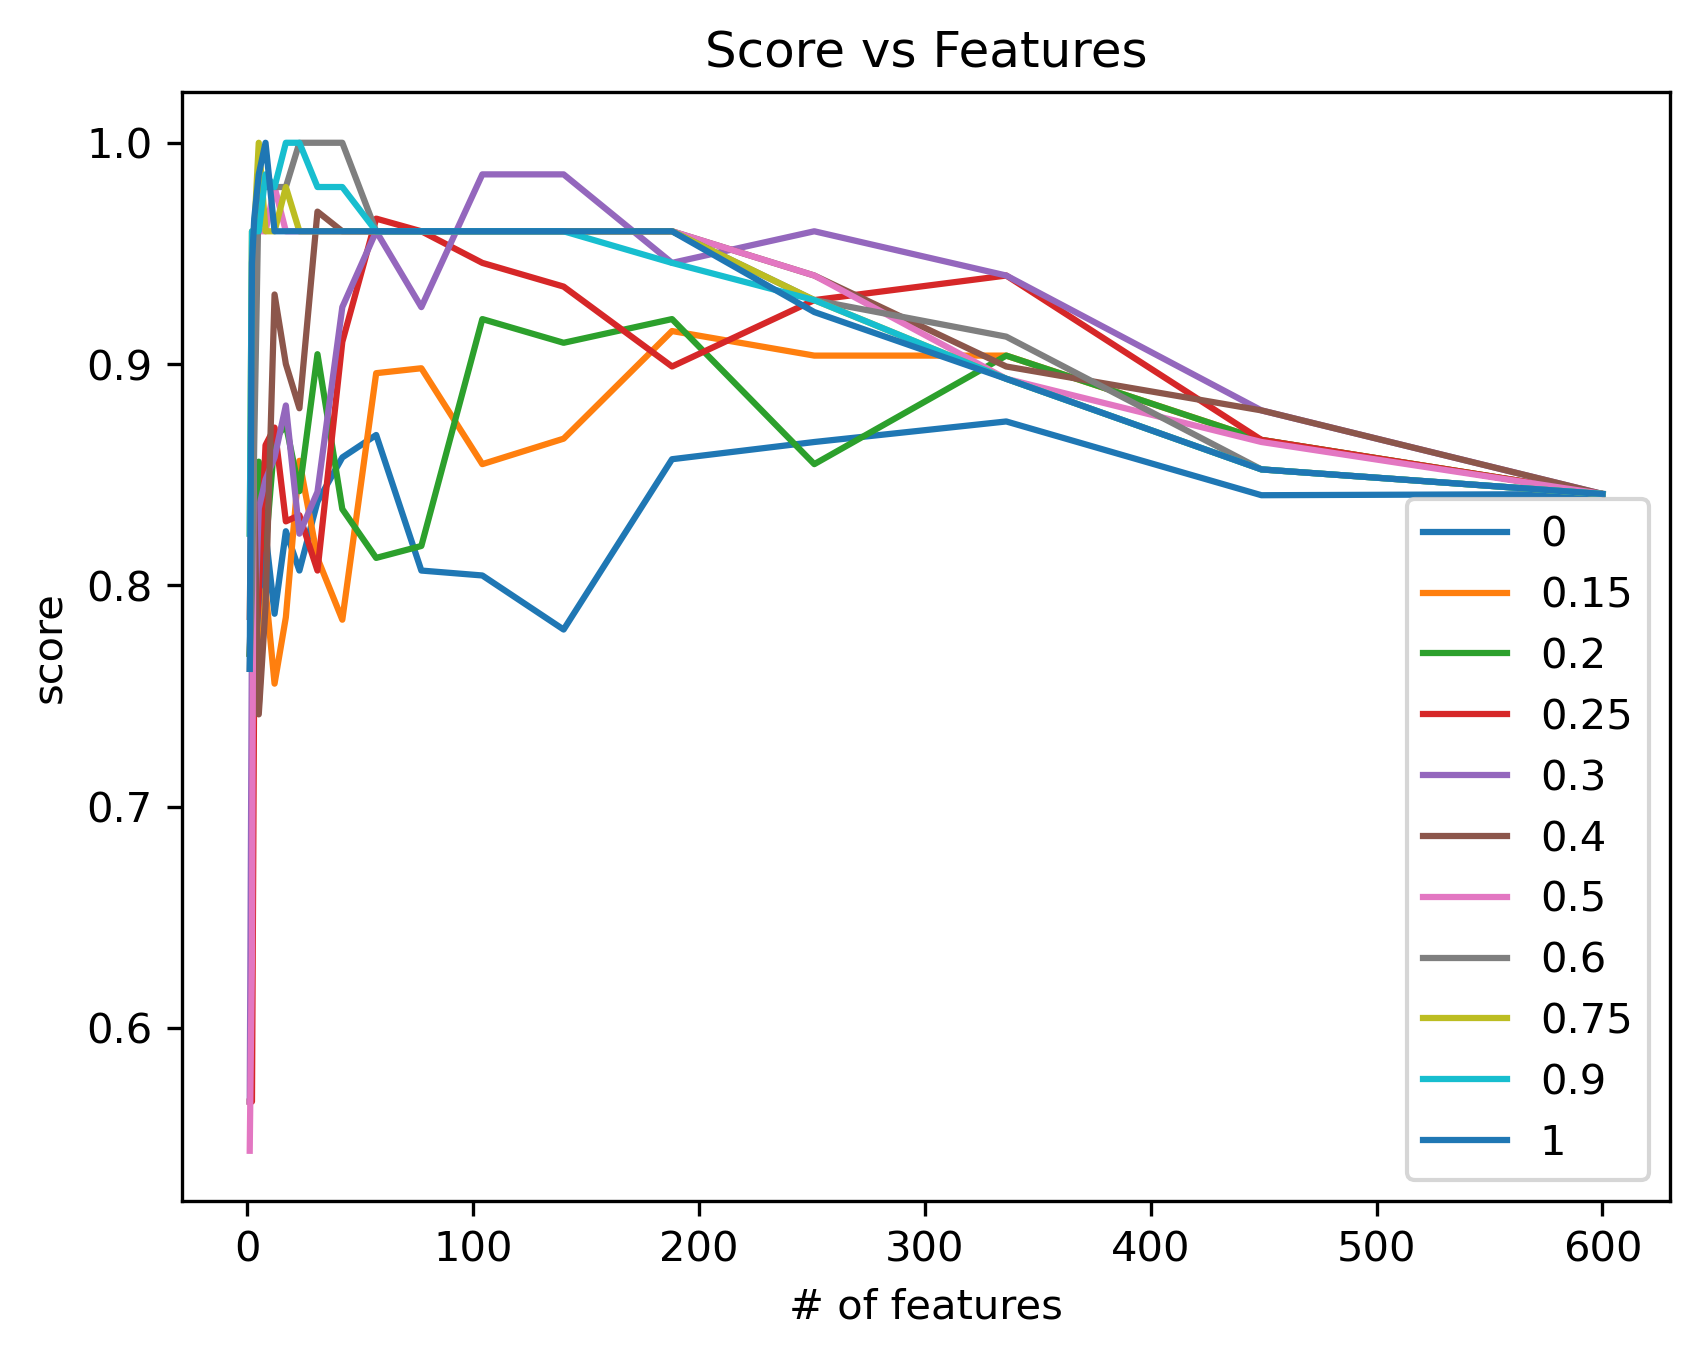

In [314]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "max"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

In [315]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.8413574074074074,
 0.872869708994709,
 0.8727039021164021,
 0.8979990740740741,
 0.9148785714285714,
 0.9090402777777778,
 0.9082999999999999,
 0.909915343915344,
 0.905182671957672,
 0.9053945767195768,
 0.9044470899470899]

In [316]:
svm_set_ranks[selected_run].performance_

{'f1': 0.9714285714285715,
 'auc': 1.0,
 'score': 0.9857142857142858,
 'C': 0.03125,
 'num_features': 104,
 'mean_nSV': 20.2}

In [317]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [318]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [319]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [320]:
df_blindprediction

,f1,auc,true neg,false pos,false neg,true pos,precision or PPV,recall or TPR,specificity or TNR
0,0.800000,0.80,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.15,0.800000,0.90,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.2,0.800000,0.80,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.25,0.888889,0.80,4.0,1.0,0.0,4.0,0.800000,1.00,0.8
0.3,0.800000,0.80,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.4,0.800000,0.95,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.5,0.888889,0.85,4.0,1.0,0.0,4.0,0.800000,1.00,0.8
0.6,0.800000,0.90,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.75,0.800000,0.90,3.0,2.0,0.0,4.0,0.666667,1.00,0.6
0.9,0.888889,0.90,4.0,1.0,0.0,4.0,0.800000,1.00,0.8


In [321]:
df_performance

,f1,auc,score,C,num_features,mean_nSV
0,0.814762,0.933333,0.874048,0.015625,336.0,22.4
0.15,0.874286,0.955556,0.914921,0.031250,188.0,21.8
0.2,0.862857,0.977778,0.920317,0.062500,104.0,19.4
0.25,0.931429,1.000000,0.965714,0.125000,57.0,17.0
0.3,0.971429,1.000000,0.985714,0.031250,104.0,20.2
0.4,0.960000,0.977778,0.968889,0.250000,31.0,13.6
0.5,0.960000,1.000000,0.980000,0.125000,12.0,11.8
0.6,1.000000,1.000000,1.000000,0.015625,23.0,22.0
0.75,1.000000,1.000000,1.000000,4.000000,5.0,9.4
0.9,1.000000,1.000000,1.000000,0.015625,17.0,23.0


In [322]:
df_features

,0,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.75,0.9,1
0,dx_mgus,dx_mgus,dx_mgus,BUN_mean,Albumin Electrophoresis_std,BUN_min,BUN_mean,BUN_mean,Creatinine_50%,BUN_min,BUN_50%
1,dx_mm,dx_mm,ChemoTx,BUN_min,Albumin Electrophoresis_max,BUN_25%,Chloride_min,BUN_min,Sodium_75%,BUN_25%,Chloride_25%
2,survival(mo),ChemoTx,ChemoTx_True,BUN_25%,BUN_mean,Chloride_mean,Creatinine_25%,BUN_25%,Chloride_linear_intercept,Chloride_min,Sodium_50%
3,ChemoTx,ChemoTx_True,BUN_mean,BUN_50%,BUN_min,Chloride_min,Creatinine_50%,Chloride_mean,Immature Gran Auto_linear_mse,Chloride_25%,Sodium_75%
4,HematologicTx,OtherTx_True,BUN_25%,Beta-2-Microglobulin_std,BUN_25%,Chloride_25%,Kappa Free Light Chains_min,Chloride_min,Chloride_exp_intercept,Creatinine_25%,Total Serum Protein_75%
...,...,...,...,...,...,...,...,...,...,...,...
331,NT Pro BNP_exp_coef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,NT Pro BNP_exp_intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,NT Pro BNP_exp_r2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,Troponin-T_exp_coef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
df_features['0.6'].dropna()

0                               BUN_mean
1                                BUN_min
2                                BUN_25%
3                          Chloride_mean
4                           Chloride_min
5                           Chloride_25%
6            Kappa Free Light Chains_min
7            Kappa Free Light Chains_25%
8                     Pct Neutrophil_25%
9                     Pct Neutrophil_50%
10                    Platelet Count_min
11    Serum Electrophoresis Alpha 2_mean
12     Serum Electrophoresis Alpha 2_75%
13                           Sodium_mean
14                            Sodium_25%
15                            Sodium_50%
16                            Sodium_75%
17                         BUN_linear_r2
18             Chloride_linear_intercept
19         Immature Gran Auto_linear_mse
20            Platelet Count_linear_coef
21                Chloride_exp_intercept
22                       Chloride_exp_r2
Name: 0.6, dtype: object

In [324]:
df_features['0.3'].dropna()

0                    Albumin Electrophoresis_std
1                    Albumin Electrophoresis_max
2                                       BUN_mean
3                                        BUN_min
4                                        BUN_25%
                         ...                    
99     Serum Electrophoresis Gamma_exp_intercept
100                              Sodium_exp_coef
101                          NT Pro BNP_exp_coef
102                     NT Pro BNP_exp_intercept
103                          Troponin-T_exp_coef
Name: 0.3, Length: 104, dtype: object

## best model performance

In [325]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0.3
f1                0.971429
auc               1.000000
score             0.985714
C                 0.031250
num_features    104.000000
mean_nSV         20.200000
Name: 0.3, dtype: float64
f1                    0.800000
auc                   0.800000
true neg              3.000000
false pos             2.000000
false neg             0.000000
true pos              4.000000
precision or PPV      0.666667
recall or TPR         1.000000
specificity or TNR    0.600000
Name: 0.3, dtype: float64


In [326]:
df_features[str(rank_weights[selected_run])].dropna()

0                    Albumin Electrophoresis_std
1                    Albumin Electrophoresis_max
2                                       BUN_mean
3                                        BUN_min
4                                        BUN_25%
                         ...                    
99     Serum Electrophoresis Gamma_exp_intercept
100                              Sodium_exp_coef
101                          NT Pro BNP_exp_coef
102                     NT Pro BNP_exp_intercept
103                          Troponin-T_exp_coef
Name: 0.3, Length: 104, dtype: object

## pair plots

In [327]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

ValueError: Image size of 78000x78000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x14f4578ecd60> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 78000x78000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 78000x78000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 78000x78000 with 5460 Axes>

## 3D scatter

In [ ]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [ ]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

In [ ]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [ ]:
# nbins = 10
# scale = 0.1
# n_features = 12
# spacing = 2
# min_max_IG = 2.5

# fig = go.Figure()
# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=1000,
#     height=2000,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = "Integrated Gradient",
# )
 
# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     range = [-min_max_IG,min_max_IG]
#     )
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey',
#     range = [-spacing, spacing*n_features + spacing]
# )
 
# feature_rank = np.argsort(np.sum(abs(IG),axis=0))
# feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

# y_val = 1
# bin_ids = list(range(nbins))
# for f in feature_order:
#     bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
#     ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
#     x_vals = []
#     y_vals = []
#     f_vals = []
#     for bin in bin_ids:
#         x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
#         n_pts = len(x_bin_vals)
#         if n_pts > 0:
#             x_vals = x_vals + x_bin_vals
#             y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
#             f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
#     fig.add_trace(go.Scatter(
#         x = x_vals, 
#         y = y_vals,
#         mode = 'markers',
#         marker = dict(size=12,
#                       color = f_vals,
#                       coloraxis = "coloraxis",
#                      ),
#         name=IGtable.columns[f],
#     ))
#     y_val += spacing
 
 
# fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text="Feature Value",side = "right"),
#                     cmin = -1, cmax = 1)
# fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
#                  ticktext=IGtable.columns[feature_order])
 
# fig.show()

In [ ]:
feat_1 = IGtable.columns[feature_order[6]]
feat_2 = IGtable.columns[feature_order[5]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [ ]:
feat_1 = IGtable.columns[feature_order[5]]
feat_2 = IGtable.columns[feature_order[6]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

# sensitivity and specificity 

In [ ]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

# testing alt models on best feature list

In [ ]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [ ]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

In [ ]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with DescFits Best Features")
fig.tight_layout()

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with DescFits Best Features")
fig.tight_layout()

In [ ]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

In [ ]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# exporting selected features to dataframe

In [ ]:
selected_features = list(X.columns[svm_set_ranks[selected_run].features]) #getting list of selected features
dataTablePositive = dataTable[dataTable[y_column_Classification] == 1] #filtering for positive patients
dataTablePositive.index = dataTablePositive['DeID'] #setting index to patient id
dataTableNegative = dataTable[dataTable[y_column_Classification] == 0] #filtering for negative patients
dataTableNegative.index = dataTableNegative['DeID'] #setting index to patient id
df_selectedfeatures_allpts = dataTable[selected_features]
df_selectedfeatures_allpts.index = dataTable['DeID'] #adding the patient identifiers back to the dataframe


#saving this output to a sheet
outputToExcel(df_data = df_selectedfeatures_allpts[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = dataTablePositive[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "positive")
outputToExcel(df_data = dataTableNegative[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "negative")


# correlation and heat maps for the best performing features of the SVM model

In [ ]:
import seaborn as sns

In [ ]:
dataTable

In [ ]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [ ]:
outputToExcel(df_data = feature_correlation, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = feature_correlation_CApositive, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCApos")
outputToExcel(df_data = feature_correlation_CAnegative, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCAneg")

In [ ]:
colormap = "RdBu"

In [ ]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix ,
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots(figsize = (5,7),layout = 'constrained')
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, vmin= -1, vmax = 1, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')